# Implement a 1D Plug Flow Reactor Model with Surface Chemistry

In this model, we will illustrate the derivation of the governing differential equations and algebraic constraints, calculation of the initial conditions of the variables and their primes and use the [scikits.odes.dae](http://scikits-odes.readthedocs.io/en/latest/guide.html#object-oriented-interface-ode-and-dae) IDA solver to solve this differential and algebraic equations (DAE).

In [1]:
from __future__ import print_function, division
import numpy as np
from scikits.odes import dae
import cantera as ct
import matplotlib.pyplot as plt
%matplotlib inline
from prettyplotlib import brewer2mpl
colors = brewer2mpl.get_map('Set2','qualitative',8).mpl_colors
print('Runnning Cantera version: ' + ct.__version__)

Runnning Cantera version: 2.3.0


## Define gas species, bulk species, surface species and the interface

Here, we use a kinetic mechanism involving the chemical vapor deposition of silicon nitride (Si3N4) from SiF4 and NH3. 25 gas species, 6 surface species and 2 bulk species mechanism is applied by [Richard S. Larson et al. 1996, SAND96-8211](https://github.com/yuj056/yuj056.github.io/blob/master/_posts/Sandia.pdf).

In [2]:
#import the SiF4 + NH3 reaction mechanism
mech ='reactors/data/SiF4_NH3_mec.cti'
#mech ='SiF4_NH3_mec.cti'
#import the models for gas and bulk
ct.suppress_thermo_warnings() #to ignore the warnings caused by importing the mechanism
gas, bulk_Si, bulk_N = ct.import_phases(mech,['gas','SiBulk','NBulk',])
#import the model for gas-Si-N interface
gas_Si_N_interface = ct.Interface(mech, 'SI3N4',[gas,bulk_Si,bulk_N])

# Case 1: isothermal reactor
## Define reactor conditions : temperature, pressure, fuel, and some important parameters

In [3]:
T0 = 1713 # Kelvin
p0 = 2 * ct.one_atm / 760.0 #Pa ~2Torr
gas.TPX = T0,p0,"NH3:6, SiF4:1"
bulk_Si.TP = T0,p0
bulk_N.TP = T0,p0
gas_Si_N_interface.TP = T0,p0
D = 5.08 * 10**-2 # diameter of the tube [m]
Ac = np.pi * D**2/4 # cross section of the tube [m^2]
Vdot = 588 * 10**-6/60 # volumetric rate [m^3/s]
mu = 5.7E-5 #kg/(m s) dynamic viscosity
perim = np.pi * D #perimeter of the tube
sigma_k = [2, 2, 2, 2, 4, 2] #site fraction of surface species as the same order of CTI file
#calculate the site fractions of surface species at the entrance of the tube at steady state
gas_Si_N_interface.advance_coverages(100.0) #Here we assume after 100s, the system reaches the steady state
Zk_0 = gas_Si_N_interface.coverages
N = gas.n_species #number of gas species
M = gas_Si_N_interface.n_species #number of surface species

## Define a residual function for IDA solver

For the isothermal tube with laminar flow, since the temperature of the flow and tube keeps constant the energy conservation equation can be blocked. The governing equations include conservation of mass and species, momentum equation, equation of state, and the algebraic constraints are that the net production rate of surface species by heterogeneous reactions go zero and the sum of site fraction equals 1, respectively.
Here we define a residual function,an equation which always evaluates to zero, as the input of IDA solver, which listed as follows:

In [4]:
%%latex
\begin{align}
    R[0] &= u\frac{d\rho}{dz} + \rho\frac{du}{dz} - \frac{p'}{A_c}\sum^{K_g}\dot{s_{k,g}}W_{k,g} \\
    R[1] &= \rho u A_c\frac{dY_k}{dz} + Y_k p'\sum^{K_g}\dot{s_{k,g}}W_{k,g} - \dot{\omega_k}W_kA_c - \dot{s_{k,g}}W_{k,g} p' \\
    R[2] &= 2\rho u \frac{du}{dz} + u^2\frac{d\rho}{dz} + \frac{dP}{dz} + \frac{32u\mu}{D^2}\\
    R[3] &= P\bar{W} - \rho RT\\                                                
    R[4] &= \dot{s_{k,s}} \\                 
    R[5] &= \sum_{phase}{Z_{k,s}} - 1 
\end{align}     

<IPython.core.display.Latex object>

The detailed derivation of the DAE system can be found in [my report](https://github.com/yuj056/yuj056.github.io/blob/master/Week1/yuj056_github_io.pdf).

In [5]:
def residual(z, vec, vecp, result):
    """ we create the residual equations for the problem
        vec = [u, rho, Yk, p, Zk]
        vecp = [dudz, drhodz, dYkdz, dpdz, dZkdz]
    """
    #temporary variables
    u = vec[0] #velocity
    rho = vec[1] #density
    Y = vec[2:2+N] #vector of mass fractions of all gas species
    p = vec[2+N] #pressure
    Z = vec[3+N:] #vector of site fractions of all surface species
    
    
    dudz = vecp[0] #velocity prime
    drhodz = vecp[1] #density prime
    dYdz = vecp[2:2+N] #mass fraction prime
    dpdz = vecp[2+N] #pressure prime
    
      
    #unnorimalized the mass fraction to avoid over-constrained
    gas.set_unnormalized_mass_fractions(Y)
    gas.TP = T0,p
    
    bulk_Si.TP = T0,p
    bulk_N.TP = T0,p
    
    #unnormalized the site fraction (coverages) to avoid over-constrained
    gas_Si_N_interface.set_unnormalized_coverages(Z)
    gas_Si_N_interface.TP = T0,p
    
    #temporary variables (based on the given initial condition)
    coverages = gas_Si_N_interface.coverages #site fraction vector
    sdot_g = gas_Si_N_interface.net_production_rates[:N] #heterogeneous production rate of gas species
    sdot_s = gas_Si_N_interface.net_production_rates[-M:]
    wdot_g = gas.net_production_rates #homogeneous production rate of gas species
    W_g = gas.molecular_weights #vector of molecular weight of gas species
       
    #mass continuity equation
    result[0] = u*drhodz + rho*dudz - perim*np.sum(sdot_g*W_g)/Ac
    
    #conservation of species
    for k in range(N):
        result[1+k] = rho*u*Ac*dYdz[k] + Y[k]*perim*np.sum(sdot_g*W_g)\
                      - wdot_g[k]*W_g[k]*Ac\
                      - sdot_g[k]*W_g[k]*perim 
    #conservation of momentum
    result[1+N] = 2*rho*u*dudz + np.power(u,2)*drhodz + dpdz + 32*u*mu/D**2 
    
    #equation of state
    result[2+N] = gas.density - rho
    
    #algebraic constraints
    for j in range(M):
        result[3+N+j] = sdot_s[j]

    #replace the constraints with the condition sum(Zk) = 1 for the largest site fraction species
    index = np.argmax(coverages)
    result[3+N+index] = np.sum(coverages) - 1

## Determine the initial values of the prime of the unknowns which need to be used as the input for the IDA solver

The following linear equation system has been solved by [np.linalg.solve](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.solve.html), a linear solver, to calculate the initial values of the prime of the unknowns.

In [6]:
%%latex
\begin{align}
    u_0\rho_0' + \rho_0 u_0' - \frac{p'}{A_c}\sum^{K_g}\dot{s_{k,g}}W_{k,g} &= 0\\
    \rho_0 u_0 A_c Y_{k,0}' + Y_{k,0} p'\sum^{K_g}\dot{s_{k,g}}W_{k,g} - \dot{\omega_k}W_kA_c - \dot{s_{k,g}}W_{k,g} p' &=0 \\                 
    2\rho_0 u_0 u_0' + u_0^2\rho_0' + P_0' + \frac{32u_0 \mu}{D^2} &=0\\
    -RT\rho_0' + \bar{W_0}P_0' - P_0\frac{\sum^{K_g}Y_{k}'/W_{k,g}}{(\sum^{K_g}Y_{k}/W_{k,g})^2} &= 0 
\end{align}

<IPython.core.display.Latex object>

We assume the derivatives of the site fractions equal zero, although it is trivial for the IDA solver.

In [7]:
########use linalg to solve the initial vecp###########
"""
   a = coefficient of [u', rho', Yk', P']
   b = RHS constant of each conservation equations
"""
rho0 = gas.density #initial density of the flow
u0 = 11.53 #m/s initial velocity of the flow
W = gas.molecular_weights
W_avg = gas.mean_molecular_weight
sdot = gas_Si_N_interface.net_production_rates #heterogeneous molar production rate
wdot = gas.net_production_rates #homogeneours molar production rate
################### a #########################
a = np.zeros((3+N,3+N))
a[0,:] = np.append([rho0,u0],np.zeros(1+N))
for i in range(N):
    a[1+i,2+i] = rho0*u0*Ac
a[1+N,:] = np.append(np.append([2*rho0*u0, u0**2],np.zeros(N)),[1])
coef = np.zeros(N)
for j in range(N):
    coef[j] = gas.P/W[j]/np.power(np.sum(gas.Y/W),2)
a[2+N,:] = np.append(np.append([0,ct.gas_constant*T0],coef),-W_avg)
################### b ###########################
b = np.zeros(3+gas.n_species)
b[0] = perim*np.sum(sdot[:N]*W)/Ac
for i in range(gas.n_species):
    b[1+i] = wdot[i]*W[i]*Ac\
             + sdot[i]*W[i]*perim\
             - gas.Y[i]*perim*np.sum(sdot[:N]*W) 
b[1+gas.n_species] = -32*u0*mu/D**2
b[2+gas.n_species] = 0
part_vecp0 = np.linalg.solve(a,b)
vecp0 = np.append(part_vecp0,np.zeros(M))

## Run the IDA solver to calculate the unknowns varying in the flow direction

In [8]:
solver = dae('ida', residual, 
             #compute_initcond='yp0', #If yp0, then the differential variables (y of the ode system at time 0) will be used to solve for the derivatives of the differential variables, so yp0 will be calculated
             first_step_size=1e-16,
             atol=1e-8, #absolute tolerance for solution
             rtol=1e-8, #relative tolerance for solution
             algebraic_vars_idx=[np.arange(3+N,3+N+M,1)], #If the given problem is of type DAE, some items of the residual
             #vector returned by the 'resfn' have to be treated as
                    #algebraic equations, and algebraic variables must be defined.
                    #These algebraic variables are denoted by the position (index)
                    #in the state vector y.
                    #All these indexes have to be specified in the
                    #'algebraic_vars_idx' array.
             #compute_initcond_t0 = 60,#When calculating the initial condition, specifies the time
                                      # until which the solver tries to
                                      #get the consistent values for either y0 or yp0 relative to
                                      #the starting time. Positive if t1 > t0, negative if t1 < t0
             max_steps=5000,
             old_api=False)#Forces use of old api (tuple of 7) if True or
                    #new api (namedtuple) if False.
                    #Other options may require new api, hence using this should
                    #be avoided if possible.

vec0 = np.append(np.append(np.append([11.53, gas.density], gas.Y),gas.P),Zk_0)
solution = solver.solve(np.arange(0,0.7,0.1), vec0,vecp0)

## Plot the results

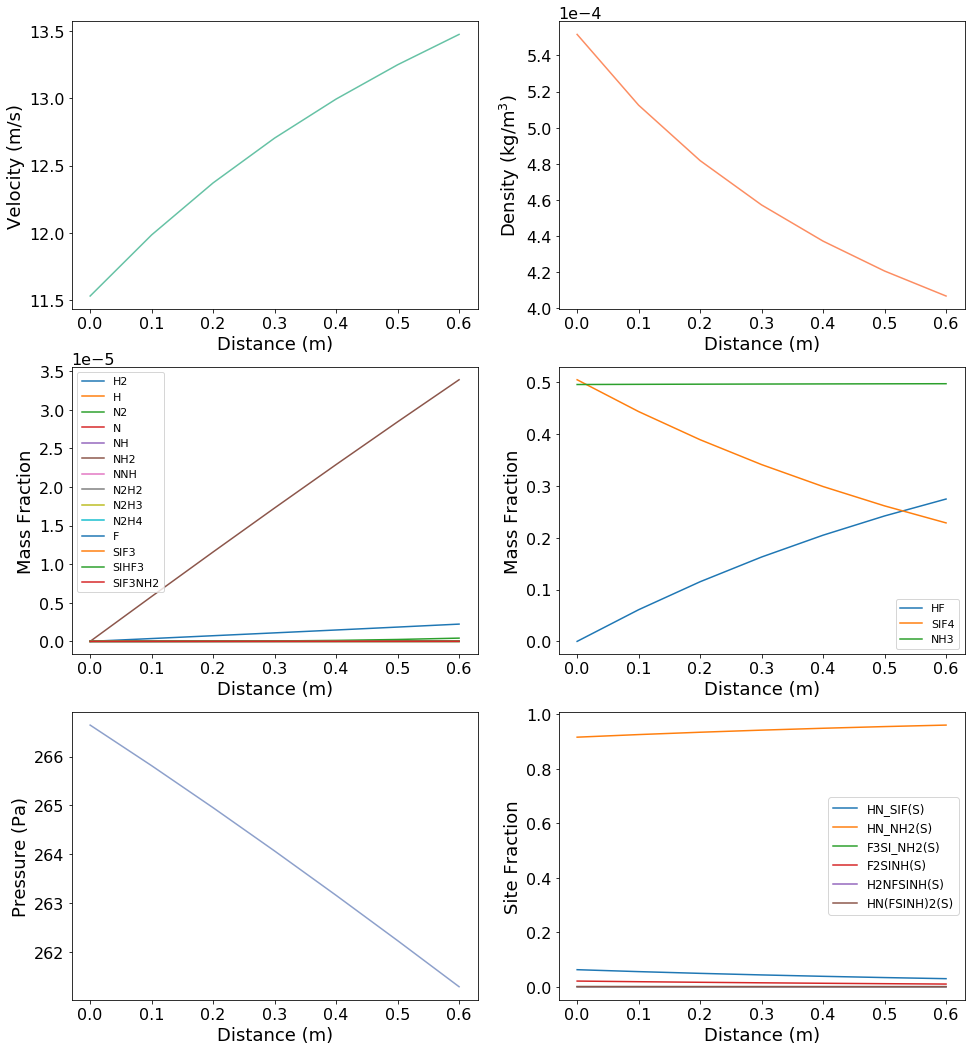

In [9]:
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

#plot velocity of gas along the flow direction
plt.figure(figsize = (16,18))
plt.subplot(3,2,1)
plt.plot(np.arange(0,0.7,0.1),solution.values.y[:,0],color = colors[0])
plt.xlabel('Distance (m)')
plt.ylabel('Velocity (m/s)')

#plot gas density along the flow direction
plt.subplot(3,2,2)
plt.plot(np.arange(0,0.7,0.1),solution.values.y[:,1],color = colors[1])
plt.xlabel('Distance (m)')
#plt.ylabel(Density r'$ (kg/m^3)$'')
plt.ylabel('Density ($\mathregular{kg/m^3}$)')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2)) #scientific notation

#plot major and minor gas species separately
minor_idx = []
major_idx = []
for i,name in enumerate(gas.species_names): 
    mean = np.mean(solution.values.y[:,2+i])
    if mean <= 0.01:
        minor_idx.append(i) 
    else:
        major_idx.append(i)

#plot minor species
plt.subplot(3,2,3)
for i in minor_idx:
    plt.plot(np.arange(0,0.7,0.1),solution.values.y[:,2+i],label = '%s'%gas.species_names[i])
plt.legend(fontsize=11,loc = 'upper left')
plt.xlabel('Distance (m)')
plt.ylabel('Mass Fraction')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2)) #scientific notation

#plot major species
plt.subplot(3,2,4)
for j in major_idx:
    plt.plot(np.arange(0,0.7,0.1),solution.values.y[:,2+j],label = '%s'%gas.species_names[j])
plt.legend(fontsize=11,loc = 'best')
plt.xlabel('Distance (m)')
plt.ylabel('Mass Fraction')

#plot the pressure of the gas along the flow direction
plt.subplot(3,2,5)
plt.plot(np.arange(0,0.7,0.1),solution.values.y[:,2+N],color = colors[2])
plt.xlabel('Distance (m)')
plt.ylabel('Pressure (Pa)')

#plot the site fraction of the surface species along the flow direction 
plt.subplot(3,2,6)
for i,name in enumerate(gas_Si_N_interface.species_names):
    plt.plot(np.arange(0,0.7,0.1),solution.values.y[:,3+N+i],label = '%s'%(name))
plt.legend(fontsize=12)
plt.xlabel('Distance (m)')
plt.ylabel('Site Fraction')
plt.show()

# Case 2: Adiabatic reactor

Since the application of isothermal reactor is not prevalent, to further complex the model for reality use the adiabatic reator is considered. Here energy balance equation should be considered.

The heat flow rate into the system has two expressions, one is due to the heat flux qe from surroundings to the outer tube wall (whose surface area per unit length is ae) and accumulation of enthalpy in the bulk solid. The other is due to the qi is the heat flux to the gas from the inner tube wall and accumulation fo enthalpy in the surface species. The expression of energy balance equation for this problem shows as follows: 

In [10]:
%%latex
\begin{align}
    \rho u A_c c_p \frac{dT}{dz} +A_c \sum_{K_g}\omega_k\dot{W_k}h_k + p'\sum_{K_g}h_k\dot{s_k}W_k &= a_eq_e - p'\sum^{K_b}_{bulk}\omega_kh_k\\&=p'q_i + p'\sum^{K_g}_{gas}\dot{s_k}W_kh_k
\end{align}

<IPython.core.display.Latex object>

Since the adiabatic reactor is considered, qe = 0. Similar procedure as isothermal reactor model, adding the energy equation into the residual function and calculate the initial value of the prime of the temperature.

In [11]:
############################### initial conditions ##################################################################
#import the SiF4 + NH3 reaction mechnism
mech ='/Users/yuanjie/Dropbox/Cantera_intern/code/gas_surf_phase/gas_surf_bulk/mec.cti'
#import the models for gas and bulk
ct.suppress_thermo_warnings()
gas, bulk_Si, bulk_N = ct.import_phases(mech,['gas','SiBulk','NBulk',])

#import the model for gas-Si-N interface
gas_Si_N_interface = ct.Interface(mech, 'SI3N4',[gas,bulk_Si,bulk_N])
T0 = 1713 #K
p0 = 2 * ct.one_atm / 760.0 #Pa ~2Torr
gas.TPX = T0,p0,"NH3:6, SiF4:1"
bulk_Si.TP = T0,p0
bulk_N.TP = T0,p0
gas_Si_N_interface.TP = T0,p0
D = 5.08 * 10**-2 #diameter of the tube [m]
Ac = np.pi * D**2/4 # cross section of the tube [m]
Vdot = 588 * 10**-6/60 # volumetric rate [m^3/s]
mu = 5.7E-5 #kg/(m s) dynamic viscosity
perim = np.pi * D #perimeter of the tube
sigma_k = [2, 2, 2, 2, 4, 2] #site fraction of surface species as the same order of CTI file
#calculate the site fractions of surface species at the entrance of the tube at steady state
gas_Si_N_interface.advance_coverages(100.0)
Zk_0 = gas_Si_N_interface.coverages
######################################## IDA solver ###################################################################
def residual(z, vec, vecp, result):
    """ we create the residual equations for the problem
        vec = [u, rho, Yk, p, Zk, T]
        vecp = [dudz, drhodz, dYkdz, dpdz, dZkdz, dTdz]
    """
    #temporary variables
    u = vec[0] #velocity
    rho = vec[1] #density
    Y = vec[2:2+N] #vector of mass fractions of all gas species
    p = vec[2+N] #pressure
    Z = vec[3+N:-1] #vector of site fractions of all surface species
    T = vec[-1] #temperature
    
    dudz = vecp[0] #velocity prime
    drhodz = vecp[1] #density prime
    dYdz = vecp[2:2+N] #mass fraction prime
    dpdz = vecp[2+N] #pressure prime
    dTdz = vecp[-1]
    
    h = gas.enthalpy_mass #enthalpy of gas species per mass
    h_Si = bulk_Si.enthalpy_mass #enthalpy of Si per mass
    h_N = bulk_N.enthalpy_mass # enthalpy of N per mass
    
    #initial conditions
    gas.set_unnormalized_mass_fractions(Y)
    gas.TP = T,p
    
    bulk_Si.TP = T,p
    bulk_N.TP = T,p
    gas_Si_N_interface.set_unnormalized_coverages(Z)
    gas_Si_N_interface.TP = T,p
    
    #temporary variables (based on the given initial condition)
    coverages = gas_Si_N_interface.coverages #site fraction vector
    sdot_g = gas_Si_N_interface.net_production_rates[:N] #heterogeneous production rate of gas species
    sdot_s = gas_Si_N_interface.net_production_rates[-M:]#molar production rate of surface speceis
    wdot_g = gas.net_production_rates #homogeneous production rate of gas species
    W_g = gas.molecular_weights #vector of molecular weight of gas species
    W_Si_b = bulk_Si.molecular_weights
    W_N_b = bulk_N.molecular_weights
    bdot = gas_Si_N_interface.net_production_rates[gas.n_species:gas.n_species+2] #bulk production rate
   
    #mass continuity equation
    result[0] = u*drhodz+rho*dudz-perim*np.sum(sdot_g*W_g)/Ac
    #conservation of species
    for k in range(gas.n_species):
        result[1+k] = rho*u*Ac*dYdz[k] + Y[k]*perim*np.sum(sdot_g*W_g)\
                      - wdot_g[k]*W_g[k]*Ac\
                      - sdot_g[k]*W_g[k]*perim 
    #conservation of momentum
    result[1+gas.n_species] = 2*rho*u*dudz + np.power(u,2)*drhodz + dpdz + 32*u*mu/D**2 
    
    #equation of state
    result[2+gas.n_species] = gas.density - rho
    
    #algebraic constraints
    for j in range(M):
        result[3+N+j] = sdot_s[j]
    
    #replace the constraints with the condition sum(Zk) = 1 for the largest site fraction species
    index = np.argmax(coverages)
    result[3+N+index] = np.sum(coverages) - 1
    
    #energy equation
    result[3+N+M] = rho*u*Ac*gas.cp*dTdz\
                 + Ac*np.sum(wdot_g*W_g*h)\
                 + perim*np.sum(h*sdot_g*W_g)\
                 + perim*np.sum(bdot*np.append(W_Si_b,W_N_b)*np.append(h_Si,h_N)) 

In [12]:
########use ling to solve the initial vecp###########
"""
   a = coefficient of [u', rho', Yk', P',T]
   b = RHS constant of each conservation equations
"""
rho0 = gas.density #initial density of the flow
u0 = 11.53 #m/s initial velocity of the flow
W = gas.molecular_weights
W_avg = gas.mean_molecular_weight
sdot = gas_Si_N_interface.net_production_rates #heterogeneous molar production rate
wdot = gas.net_production_rates #homogeneours molar production rate
h = gas.enthalpy_mass
h_Si = bulk_Si.enthalpy_mass
h_N = bulk_N.enthalpy_mass
W_Si = bulk_Si.molecular_weights
W_N = bulk_N.molecular_weights
################### a #########################
a = np.zeros((4+N,4+N))
a[0,:] = np.append([rho0,u0],np.zeros(2+N))
for i in range(N):
    a[1+i,2+i] = rho0*u0*Ac
a[1+N,:] = np.append(np.append([2*rho0*u0, u0**2],np.zeros(N)),[1,0])
coef = np.zeros(N)
for j in range(N):
    coef[j] = gas.P/W[j]/np.power(np.sum(gas.Y/W),2)
a[2+N,:] = np.append(np.append([0,ct.gas_constant*T0],coef),[-W_avg,0])
a[3+N,:] = np.append(np.zeros(3+N),rho0*u0*Ac*gas.cp)
################### b ###########################
b = np.zeros(4+gas.n_species)
b[0] = perim*np.sum(sdot[:N]*W)/Ac
for i in range(N):
    b[1+i] = wdot[i]*W[i]*Ac\
             + sdot[i]*W[i]*perim\
             - gas.Y[i]*perim*np.sum(sdot[:N]*W) 
b[1+gas.n_species] = -32*u0*mu/D**2
b[2+gas.n_species] = 0
b[3+gas.n_species] = - Ac*np.sum(wdot*W*h)\
                     - perim*np.sum(h*sdot[:N]*W)\
                     - perim*np.sum(sdot[N:N+2]*np.append(W_Si,W_N)*np.append(h_Si,h_N))
part_vecp0 = np.linalg.solve(a,b)
vecp0 = np.append(np.append(part_vecp0[:-1],np.zeros(M)),part_vecp0[-1])

In [13]:
solver = dae('ida', residual, 
             #compute_initcond='yp0', #If yp0, then the differential variables (y of the ode system at time 0) will be used to solve for the derivatives of the differential variables, so yp0 will be calculated
             first_step_size=1e-18,
             atol=1e-8, #absolute tolerance for solution
             rtol=1e-8, #relative tolerance for solution
             algebraic_vars_idx=[np.arange(3+N,3+N+M,1)], #If the given problem is of type DAE, some items of the residual
             #algebraic_vars_idx=[19, 20, 21, 22, 23, 24],
             #vector returned by the 'resfn' have to be treated as
                    #algebraic equations, and algebraic variables must be defined.
                    #These algebraic variables are denoted by the position (index)
                    #in the state vector y.
                    #All these indexes have to be specified in the
                    #'algebraic_vars_idx' array.
             #compute_initcond_t0 = 60,#When calculating the initial condition, specifies the time
                                      # until which the solver tries to
                                      #get the consistent values for either y0 or yp0 relative to
                                      #the starting time. Positive if t1 > t0, negative if t1 < t0
             max_steps=5000,
             old_api=False)#Forces use of old api (tuple of 7) if True or
                    #new api (namedtuple) if False.
                    #Other options may require new api, hence using this should
                    #be avoided if possible.

vec0 = np.append(np.append(np.append(np.append([11.53, gas.density], gas.Y),gas.P),Zk_0),T0)
solution = solver.solve(np.arange(0,0.7,0.1), vec0,vecp0)

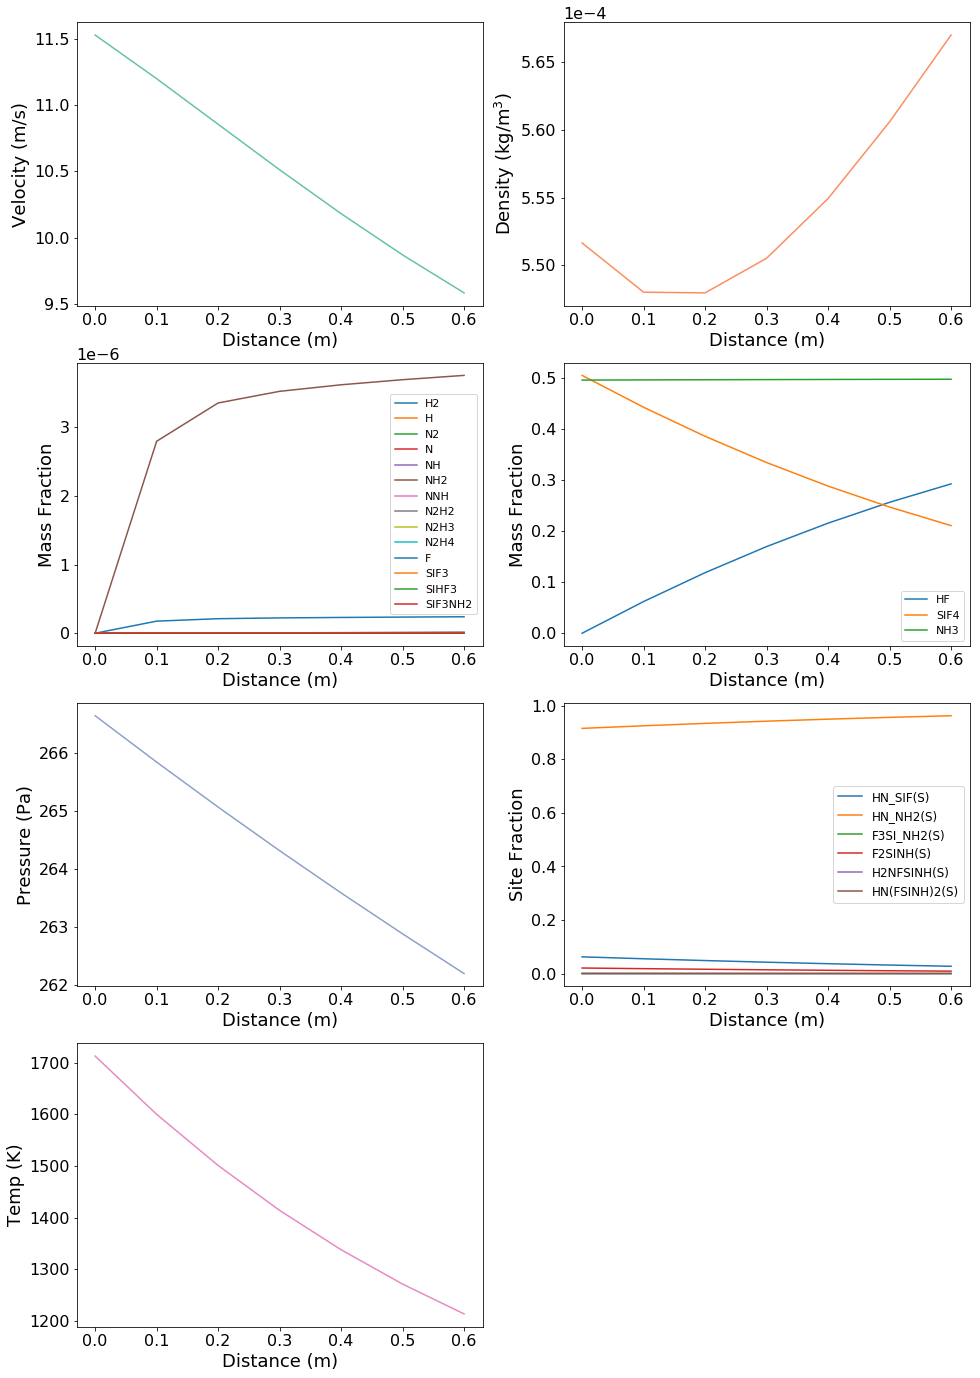

In [14]:
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

#plot gas velocity along the flow direction
plt.figure(figsize = (16,24))
plt.subplot(4,2,1)
plt.plot(np.arange(0,0.7,0.1),solution.values.y[:,0],color = colors[0])
plt.xlabel('Distance (m)')
plt.ylabel('Velocity (m/s)')

#plot gas density along the flow direction
plt.subplot(4,2,2)
plt.plot(np.arange(0,0.7,0.1),solution.values.y[:,1],color = colors[1])
#matplotlib.axes.Axes.ticklabel_format(style='sci',axis = 'y')
plt.xlabel('Distance (m)')
plt.ylabel('Density ($\mathregular{kg/m^3}$)')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2)) #scientific notation


#plot major and minor gas species separately
minor_idx = []
major_idx = []
for i,name in enumerate(gas.species_names): 
    mean = np.mean(solution.values.y[:,2+i])
    if mean <= 0.01:
        minor_idx.append(i) 
    else:
        major_idx.append(i)

#plot minor gas species along the flow direction
plt.subplot(4,2,3)
for i in minor_idx:
    plt.plot(np.arange(0,0.7,0.1),solution.values.y[:,2+i],label = '%s'%gas.species_names[i])
plt.legend(fontsize=11,loc = 'best')
plt.xlabel('Distance (m)')
plt.ylabel('Mass Fraction')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2)) #scientific notation

#plot major gas species along the flow direction
plt.subplot(4,2,4)
for j in major_idx:
    plt.plot(np.arange(0,0.7,0.1),solution.values.y[:,2+j],label = '%s'%gas.species_names[j])
plt.legend(fontsize=11,loc = 'best')
plt.xlabel('Distance (m)')
plt.ylabel('Mass Fraction')

#plot the pressure of the gas along the flow direction
plt.subplot(4,2,5)
plt.plot(np.arange(0,0.7,0.1),solution.values.y[:,2+N],color = colors[2])
plt.xlabel('Distance (m)')
plt.ylabel('Pressure (Pa)')

#plot the site fraction of the surface species along the flow direction
plt.subplot(4,2,6)
for i,name in enumerate(gas_Si_N_interface.species_names):
    plt.plot(np.arange(0,0.7,0.1),solution.values.y[:,3+N+i],label = '%s'%(name))
plt.legend(fontsize = 12)
plt.xlabel('Distance (m)')
plt.ylabel('Site Fraction')

#plot the temperature profile along the flow direction
plt.subplot(4,2,7)
plt.plot(np.arange(0,0.7,0.1),solution.values.y[:,-1],color = colors[3])
plt.xlabel('Distance (m)')
plt.ylabel('Temp (K)')
plt.show()